In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import os
# import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:

source_dir = '/home/mohit/mohit stuff/learning/analysis/data/sameroi'
data = io.loadmat(os.path.join(source_dir, "BCI13_combined_sept2021.mat"))

def rollingfun(y, window = 10, func = 'mean'):
    """
    rollingfun
        rolling average, min, max or std
    
    @input:
        y = array, window, function (mean,min,max,std)
    """
    if len(y)<=window:
        if func =='mean':
            out = np.ones(len(y))*np.nanmean(y)
        elif func == 'min':
            out = np.ones(len(y))*np.nanmin(y)
        elif func == 'max':
            out = np.ones(len(y))*np.nanmaxn(y)
        elif func == 'std':
            out = np.ones(len(y))*np.nanstd(y)
        elif func == 'median':
            out = np.ones(len(y))*np.nanmedian(y)
        else:
            print('undefinied funcion in rollinfun')
    else:
        y = np.concatenate([y[window::-1],y,y[:-1*window:-1]])
        ys = list()
        for idx in range(window):    
            ys.append(np.roll(y,idx-round(window/2)))
        if func =='mean':
            out = np.nanmean(ys,0)[window:-window]
        elif func == 'min':
            out = np.nanmin(ys,0)[window:-window]
        elif func == 'max':
            out = np.nanmax(ys,0)[window:-window]
        elif func == 'std':
            out = np.nanstd(ys,0)[window:-window]
        elif func == 'median':
            out = np.nanmedian(ys,0)[window:-window]
        else:
            print('undefinied funcion in rollinfun')
    return out

`data['data']` for Day 1. Accessed by `data['data'[:, 0][key]`
```
df: [8974×219 double]  # time x n_cells
dist: [206.0104 309.5024 160.7718 347.8765 109.8418 105.0910 84.4334 … ] 
F: [1000×219×89 double] # time x n_cells x sessions
epoch: [5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 … ] 
tsta: [-2.0089 -1.9574 -1.9058 -1.8543 -1.8028 -1.7513 -1.6998 -1.6483 … ] 
raw: [8974×219 double] # time x n_cells
file: 'F:\BCI\BCI13\090521\session_090521_analyzed_dat_small_neuron2_22090521.mat' 
cn: 27 # index (remember to subtract 1 for matlab to python indexing
IM: [800×800 single] # meanImg 
roi: [1×219 struct] 
```

In [3]:
n_days = data['data'].shape[1]

cni = [data['data'][:, i]['cn'][0][0][0] - 1 for i in range(n_days)] # -1 to account for matlab indexing
dFF = [data['data'][:, i]['df'][0] for i in range(n_days)]
dist = [data['data'][:, i]['dist'][0] for i in range(n_days)]
meanImg = [data['data'][:, i]['IM'][0] for i in range(n_days)]
raw = [data['data'][:, i]['raw'][0] for i in range(n_days)]
F_trialwise = [data['data'][:, i]['F'][0] for i in range(n_days)]
tsta = [data['data'][:, i]['tsta'][0] for i in range(n_days)]
total_steps = [dFF[i].shape[0] for i in range(n_days)]
n_trials = [F_trialwise[i].shape[-1] for i in range(n_days)]
epoch = [data['data'][:, i]['epoch'][0] for i in range(n_days)]
lkeys = [[1,3], 1, 4, 2]
epoch_closedloop = [np.isin(epoch[i],lkeys[i])[0] for i in range(n_days)]

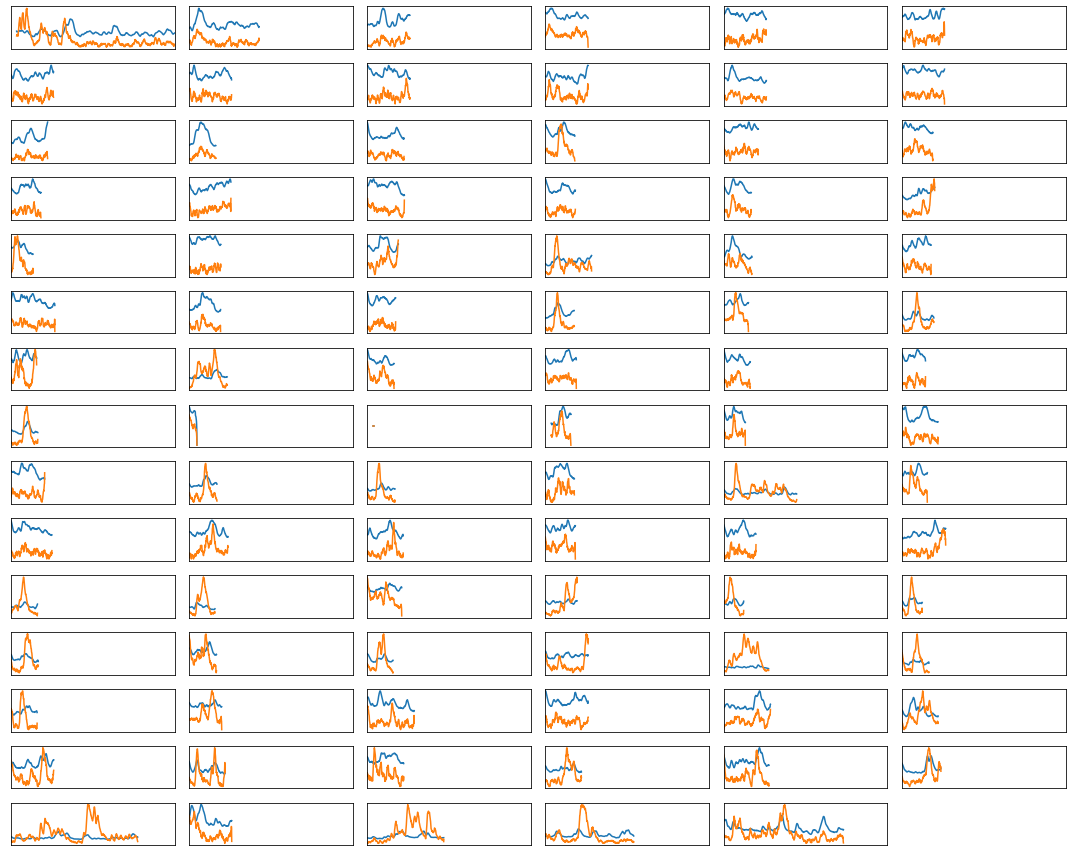

In [4]:
def plot_all_trials(day):
    n_cols = 6
    n_rows = n_trials[day]//n_cols + 1
    x_range = np.linspace(0, 10, 1000)
    plt.figure(figsize=(15,12))
    for i in range(n_trials[day]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(x_range, rollingfun(F_trialwise[day][:, :, i].mean(axis=1)))
        plt.plot(x_range, rollingfun(F_trialwise[day][:, :, i][:, cni[0]]))
        plt.xlim([0, 10])
    #     plt.ylim([0, 5])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    
day = 0
plot_all_trials(day)

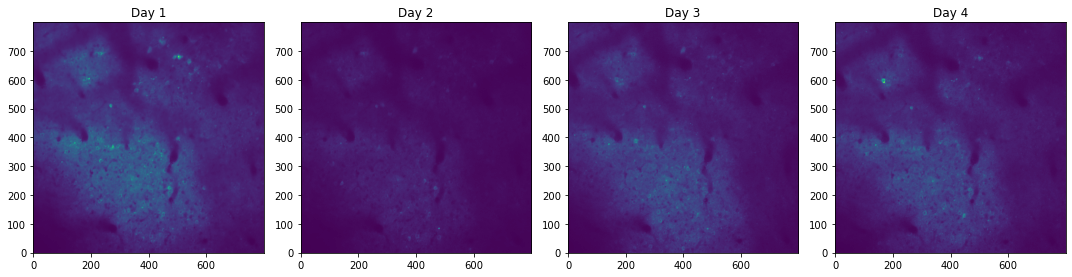

In [5]:
fig, axis = plt.subplots(1, n_days, figsize=(15, 15))
# fig.suptitle("Mean Image of the ROI", y=1.05)
for i in range(n_days):
    axis[i].imshow(meanImg[i], origin='lower')
    axis[i].set_title(f'Day {i+1}')
plt.tight_layout()
plt.show()

In [6]:
# Gaussian Filter the data 
from scipy.ndimage import gaussian_filter1d
def brody_analysis(day=0):
    # Calculate the covariance matrix of the data
    R = F_trialwise[day][100:500]
    R_trial_averaged = gaussian_filter1d(np.nanmean(R, axis=2), sigma=3, axis=0)
    R_filter = gaussian_filter1d(np.nan_to_num(R), sigma=3, axis=0)
    R_mean_sub = R_trial_averaged - np.tile(np.nanmean(R_trial_averaged, axis=0), (R_filter.shape[0], 1))
    C = np.dot(R_mean_sub.T, R_mean_sub)/R_mean_sub.shape[0]
    # plt.plot(R[:, 1, 0]) # neuron 1 in trial 0
    # plt.plot(R_filter[:, 1, 0], "-")
    # plt.plot(R_trial_averaged[:, 1], "-") # neuron 1 trial average firing rate
    # plt.show()
    # SVD to get UAU.T
    from scipy.linalg import eig, inv
    eVals, eVecs = eig(C)
    U = eVecs
    D = np.zeros((len(eVals), len(eVals)))
    for i in range(len(eVals)):
        D[i, i] = eVals[i].real

    Uinv = inv(U)

    assert np.allclose(U@D@Uinv, C) #assert both matrix are same

    # data along the new coordiante system
    Z = np.dot(R_mean_sub, U)

    # taking last 2/3 to calculate random noise since these trials mostly have full 1000ms
    eta_avg = (R_filter[:, :, -3] - R_filter[:, :, -2])/np.sqrt(2*R_filter.shape[2])
    eta_avg_sub = eta_avg - np.tile(np.nanmean(eta_avg, axis=0), (eta_avg.shape[0], 1))
    H = np.dot(eta_avg_sub.T, eta_avg_sub)/eta_avg_sub.shape[0]
    Q = C - H
    eVals_H, eVecs_H = eig(H)
    U_H = eVecs_H
    D_H = np.zeros((len(eVals_H), len(eVals_H)))
    for i in range(len(eVals_H)):
        D_H[i, i] = eVals_H[i].real

    Uinv_H = inv(U_H)

    assert np.allclose(U_H@D_H@Uinv_H, H) #assert both matrix are same

    plot_brody(eVals, eVals_H)



In [7]:
import seaborn as sns
def plot_brody(eVals, eVals_H):
    var_exp = np.cumsum(eVals)/np.sum(eVals)
    var_exp_H = np.cumsum(eVals_H)/np.sum(eVals_H)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(eVals)
    plt.plot(eVals_H)
    plt.yscale('log')
    plt.xlabel("# Components")
    plt.ylabel("Variance $Hz^2$")

    plt.subplot(132)
    plt.plot(eVals, marker='o')
    plt.plot(eVals_H, marker='o')
    plt.xlim([0, 10])
    # plt.yscale('log')
    plt.xlabel("# Components")
    plt.ylabel("Variance $Hz^2$")

    plt.subplot(133)
    plt.plot(var_exp*100, marker='o')
    plt.plot(var_exp_H*100, marker='o')
    plt.xlim([0, 10])
    plt.xlabel("# Components")
    plt.ylabel("Variance Explained $Hz^2$")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [8]:
# orange line in third plot moves up as day progresses. So although variance of blue line is bigger(plot 2), the variance explained by the
# 1st noise component increases.

In [9]:
# brody_analysis(day=0)
# brody_analysis(day=1)
# brody_analysis(day=2)
# brody_analysis(day=3)

In [97]:
import utils
import importlib
importlib.reload(utils)
day = 2

In [98]:
# day = 0
# F = F_trialwise[day][:200, :, epoch_closedloop[day]]
# R = gaussian_filter1d(np.nanmean(F[:,:, :], axis=-1), sigma=1, axis=0)
# Rold = R
# R = R - np.tile(np.mean(R[0:40, :], axis=0), (R.shape[0], 1))
# plt.plot(R[:, cni[1]])
# # plt.axhline(baseline_cni, xmax=0.2, color='r', ls='--')
# # plt.axvline(arg_extrema, color='g', ls='--')
# # plt.plot(np.arange(0, 40, 1), baseline_cni)
# plt.title("CN")
# plt.show()

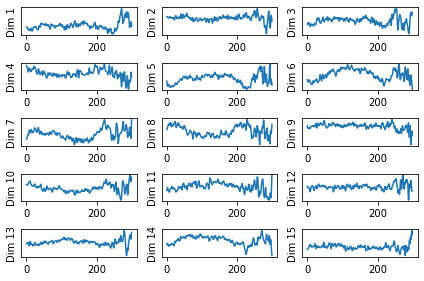

In [99]:
F = F_trialwise[day][:300, :, epoch_closedloop[day]]
R = gaussian_filter1d(np.nanmean(F[:,:, :], axis=-1), sigma=1, axis=0)
Rold = R
R = R - np.tile(np.mean(R[0:40, :], axis=0), (R.shape[0], 1))
utils.activity_along_dims(R)

# cant really see the noise and signal using dimensions. 

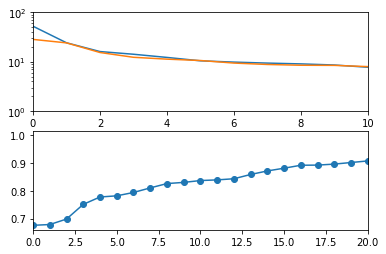

In [100]:
# Reproduce kayvons plots
ind = np.arange(0, F.shape[-1], 1, dtype=np.int64)
np.random.shuffle(ind)

R1 = gaussian_filter1d(np.nanmean(F[:,:, ind[:len(ind)//2]], axis=-1), sigma=1, axis=0)
R2 = gaussian_filter1d(np.nanmean(F[:, :, ind[len(ind)//2:]], axis=-1), sigma=1, axis=0)
R = gaussian_filter1d(np.nanmean(F[:,:, :], axis=-1), sigma=1, axis=0)

# subtract baseline (initial 40 steps)
R = R - np.tile(np.mean(R[0:40, :], axis=0), (R.shape[0], 1))
R1 = R1 - np.tile(np.mean(R1[0:40, :], axis=0), (R1.shape[0], 1))
R2 = R2 - np.tile(np.mean(R2[0:40, :], axis=0), (R2.shape[0], 1))

[U1, sig, V1] = np.linalg.svd(R1+R2)
[U2, noise, V2] = np.linalg.svd(R1-R2)

plt.subplot(211)
plt.xlim([0,10])
plt.ylim([10**-0, 10**2])
plt.semilogy(sig)
plt.semilogy(noise)

sig = sig - noise
variance = np.sqrt(sig**2/2)
plt.subplot(212)
plt.plot(np.cumsum(variance)/np.sum(variance), 'o-')
plt.xlim([0, 20])
plt.show()


### Dimensionality according to Variance explained

$dim = min \{ i| \sum_0^i var\_exp \geq 0.9\}$

In [101]:
dim_cutoff = utils.var_cutoff(variance, 0.9)
print(dim_cutoff)

20


### Participation ratio. 
$PR = \frac{(\sum_1^N{\lambda_i})^2}{\sum_i^N{\lambda_i^2}}$

In [102]:
PR_full = utils.participation_ratio1(R)
PR_sig = utils.participation_ratio2(R1, R2)
print(f'Dimensionality of Noise+Signal = {PR_full} \nDimensionality of Signal = {PR_sig}')

Dimensionality of Noise+Signal = 3.7659069204192734 
Dimensionality of Signal = 1.0239800147987808


### To establish dimensionality
Altan E, Solla SA, Miller LE, Perreault EJ (2021) Estimating the dimensionality of the manifold underlying multi-electrode neural recordings. PLoS Comput Biol 17(11): e1008591. https://doi.org/10.1371/journal.pcbi.1008591 \


#### Obtain upper bound estimate(80\% variance, or use PR) $\rightarrow$ denoise using PCA $\rightarrow$ compare variance accounted for $\rightarrow$ dim reduction based on linearity of data

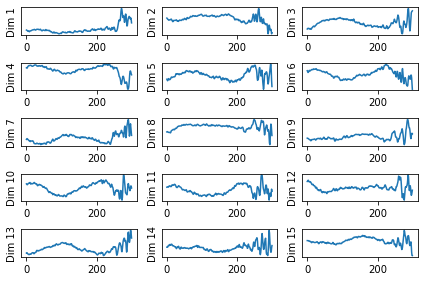

6.211797855071889


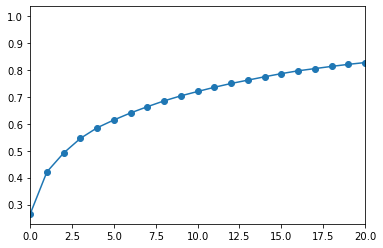

In [103]:
pcamodel, Rhat = utils.reconstruct_data(R, int(np.ceil(dim_cutoff)))
utils.activity_along_dims(Rhat)
eig_reconstructed = pcamodel.components_
PR_full = utils.participation_ratio1(Rhat)
print(PR_full)
plt.plot(np.cumsum(pcamodel.explained_variance_)/np.sum(pcamodel.explained_variance_), 'o-')
plt.xlim([0, 20])
plt.show()


In [104]:
from sklearn import metrics
vaf = metrics.explained_variance_score(R, Rhat)
print(vaf)

0.7763780684442653


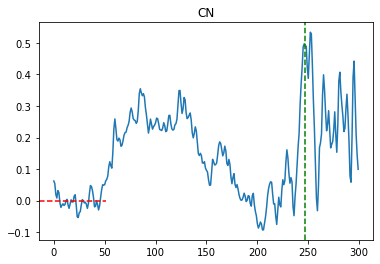

In [105]:
from scipy.signal import argrelextrema

baseline = np.mean(R[:40, :], axis=0)
baseline_cni = baseline[cni[0]]
arg_extrema = np.argmax((rollingfun(R[:, cni[0]], 5)))
plt.plot(R[:, cni[0]])
plt.axhline(baseline_cni, xmax=0.2, color='r', ls='--')
plt.axvline(arg_extrema, color='g', ls='--')
# plt.plot(np.arange(0, 40, 1), baseline_cni)
plt.title("CN")
plt.show()

In [106]:
# learning vector as difference between top day x - baseline day x
learning_vec = np.zeros(R.shape[1])
# for i in range(learning_vec.shape[0]):
#     learning_vec[i] = R[arg_extrema, i] - baseline[i]

# learning vector as difference between day x+1 and day x
daylv = day
F_x_0 = F_trialwise[daylv][:300, :, epoch_closedloop[daylv]]
R_x_0 = gaussian_filter1d(np.nanmean(F_x_0[:,:, :], axis=-1), sigma=1, axis=0)

F_x_1 = F_trialwise[daylv+1][:300, :, epoch_closedloop[daylv+1]]
R_x_1 = gaussian_filter1d(np.nanmean(F_x_1[:,:, :], axis=-1), sigma=1, axis=0)

learning_vec =  np.mean(R_x_1, axis=0) - np.mean(R_x_0, axis=0) 

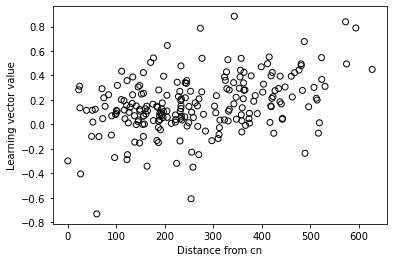

In [107]:
plt.scatter(dist[day].T, learning_vec, facecolors='none', edgecolors='black')
plt.xlabel("Distance from cn")
plt.ylabel("Learning vector value")
plt.show()

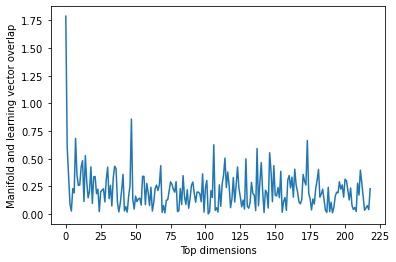

In [108]:
from matplotlib.ticker import MaxNLocator
overlap = np.abs(eig_reconstructed@learning_vec)
plt.plot(overlap)
# plt.xlim([-1,20])
plt.xlabel("Top dimensions")
plt.ylabel("Manifold and learning vector overlap")
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(plt.axes().get_xticks()+1)
plt.show()

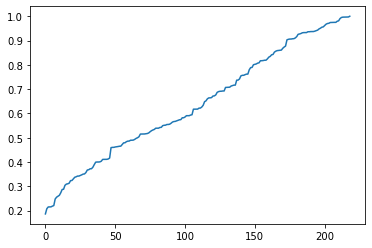

In [109]:
sq_overlap = overlap**2
plt.plot(np.cumsum(sq_overlap)/np.sum(sq_overlap))

In [113]:
np.sum(overlap[:5])/np.sum(overlap)

0.061163843405418306